In [1]:
import tensorflow as tf
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
# Data Preparation
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [3]:
# Define source and destination directories
train_source_dir = r"D:\dataset\archive\Train"
test_source_dir = r"D:\dataset\archive\Test"
train_sep_dir = "train_sep"
test_sep_dir = "test_sep"


In [4]:
# Define subfolders to be copied
subfolders_to_copy = ['RoadAccidents', 'Vandalism','Abuse','Arrest','Arson','Burglary','Fighting','Robbery']

In [5]:
# Create 'train_sep' and 'test_sep' directories if they don't exist
os.makedirs(train_sep_dir, exist_ok=True)
os.makedirs(test_sep_dir, exist_ok=True)


In [6]:
# Function to copy first n files from source directory to destination directory
def copy_first_n_files(src_dir, dest_dir, n):
    os.makedirs(dest_dir, exist_ok=True)
    files = os.listdir(src_dir)[:n]
    for file in files:
        src_file = os.path.join(src_dir, file)
        dest_file = os.path.join(dest_dir, file)
        shutil.copy(src_file, dest_file)

In [7]:
# Copy first 1000 files from each subfolder in 'train' directory to 'train_sep' directory
for subfolder in subfolders_to_copy:
    src_folder = os.path.join(train_source_dir, subfolder)
    dest_folder = os.path.join(train_sep_dir, subfolder)
    copy_first_n_files(src_folder, dest_folder, 1000)


In [8]:
# Copy first 500 files from each subfolder in 'test' directory to 'test_sep' directory
for subfolder in subfolders_to_copy:
    src_folder = os.path.join(test_source_dir, subfolder)
    dest_folder = os.path.join(test_sep_dir, subfolder)
    copy_first_n_files(src_folder, dest_folder, 500)


In [9]:
# Copy first 1000 files from 'normal' subfolder in 'train' directory to 'train_sep' directory
src_normal_folder = os.path.join(train_source_dir, 'NormalVideos')
dest_normal_folder = os.path.join(train_sep_dir, 'NormalVideos')
os.makedirs(dest_normal_folder, exist_ok=True)
normal_files = os.listdir(src_normal_folder)[:1000]
for file in normal_files:
    src_file = os.path.join(src_normal_folder, file)
    dest_file = os.path.join(dest_normal_folder, file)
    shutil.copy(src_file, dest_file)


In [10]:
# Copy first 500 files from 'normal' subfolder in 'test' directory to 'test_sep' directory
src_normal_folder = os.path.join(test_source_dir, 'NormalVideos')
dest_normal_folder = os.path.join(test_sep_dir, 'NormalVideos')
os.makedirs(dest_normal_folder, exist_ok=True)
normal_files = os.listdir(src_normal_folder)[:500]
for file in normal_files:
    src_file = os.path.join(src_normal_folder, file)
    dest_file = os.path.join(dest_normal_folder, file)
    shutil.copy(src_file, dest_file)

In [11]:
# Load data
train_generator = train_datagen.flow_from_directory(
        train_sep_dir,
        target_size=(64, 64),
        batch_size=32,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        test_sep_dir,
        target_size=(64, 64),
        batch_size=32,
        class_mode='binary')


Found 39663 images belonging to 9 classes.
Found 8297 images belonging to 9 classes.


In [12]:
# Load pre-trained ResNet50 model + higher level layers
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
base_model.trainable = False

In [13]:
# Function to extract features
def extract_features(generator, num_samples):
    features = []
    labels = []
    for inputs_batch, labels_batch in generator:
        features_batch = base_model.predict(inputs_batch)
        features.append(features_batch)
        labels.append(labels_batch)
        if len(features) * generator.batch_size >= num_samples:
            break
    features = np.concatenate(features)[:num_samples]
    labels = np.concatenate(labels)[:num_samples]
    return features, labels

In [14]:
# Number of samples
num_train_samples = train_generator.samples
num_test_samples = test_generator.samples


In [15]:
# Extract features for training and testing
train_features, train_labels = extract_features(train_generator, num_train_samples)
test_features, test_labels = extract_features(test_generator, num_test_samples)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [16]:
# Print shape before flattening
print(f'Original train features shape: {train_features.shape}')
print(f'Original test features shape: {test_features.shape}')

Original train features shape: (39663, 2, 2, 2048)
Original test features shape: (8297, 2, 2, 2048)


In [17]:
# Flatten extracted features
train_features = np.reshape(train_features, (num_train_samples, -1))
test_features = np.reshape(test_features, (num_test_samples, -1))


In [18]:
# Print shape after flattening
print(f'Flattened train features shape: {train_features.shape}')
print(f'Flattened test features shape: {test_features.shape}')

Flattened train features shape: (39663, 8192)
Flattened test features shape: (8297, 8192)


In [19]:
# Standardize features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

In [20]:
# Print shape after standardization
print(f'Standardized train features shape: {train_features.shape}')
print(f'Standardized test features shape: {test_features.shape}')

Standardized train features shape: (39663, 8192)
Standardized test features shape: (8297, 8192)


In [21]:
# Dimensionality reduction using PCA
pca = PCA(n_components=100)  # Adjust the number of components based on your dataset
train_features = pca.fit_transform(train_features)
test_features = pca.transform(test_features)

In [22]:
# Print shape after PCA
print(f'PCA reduced train features shape: {train_features.shape}')
print(f'PCA reduced test features shape: {test_features.shape}')

PCA reduced train features shape: (39663, 100)
PCA reduced test features shape: (8297, 100)


In [23]:
# Train and ensemble classifiers
knn = KNeighborsClassifier(n_neighbors=5)
svm = SVC(probability=True)
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

In [24]:
# Create a voting classifier (ensemble model)
ensemble = VotingClassifier(estimators=[
    ('knn', knn),
    ('svm', svm),
    ('rf', rf)
], voting='soft')

In [25]:
# Train the ensemble model with a smaller subset of data
subset_size = 1000  # Adjust based on your hardware capabilities
subset_indices = np.random.choice(len(train_features), subset_size, replace=False)
ensemble.fit(train_features[subset_indices], train_labels[subset_indices])


VotingClassifier(estimators=[('knn', KNeighborsClassifier()),
                             ('svm', SVC(probability=True)),
                             ('rf', RandomForestClassifier(n_jobs=-1))],
                 voting='soft')

In [26]:
# Make predictions
test_predictions = ensemble.predict(test_features)
test_probabilities = ensemble.predict_proba(test_features)


In [27]:
# Generate and print the classification report
report = classification_report(test_labels, test_predictions)
print(report)

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       297
         1.0       0.20      0.00      0.00       500
         2.0       0.00      0.00      0.00       500
         3.0       0.00      0.00      0.00       500
         4.0       0.00      0.00      0.00       500
         5.0       0.55      0.95      0.70      2500
         6.0       0.60      0.95      0.73      2500
         7.0       0.00      0.00      0.00       500
         8.0       0.00      0.00      0.00       500

    accuracy                           0.57      8297
   macro avg       0.15      0.21      0.16      8297
weighted avg       0.36      0.57      0.43      8297



C:\Users\91988\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\91988\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\91988\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [28]:
# Evaluate the model on the test set
accuracy = ensemble.score(test_features, test_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 57.10%


In [29]:
# Predict the type of crime for a single test sample
sample_index = 0  # change this index to test different samples
sample_features = test_features[sample_index].reshape(1, -1)
predicted_class = ensemble.predict(sample_features)
predicted_probabilities = ensemble.predict_proba(sample_features)
print(f'Predicted class: {predicted_class[0]}')
print(f'Predicted probabilities: {predicted_probabilities[0]}')

Predicted class: 6.0
Predicted probabilities: [0.0127482  0.01519238 0.00562677 0.00194873 0.01058919 0.37565551
 0.54989934 0.00488036 0.02345952]


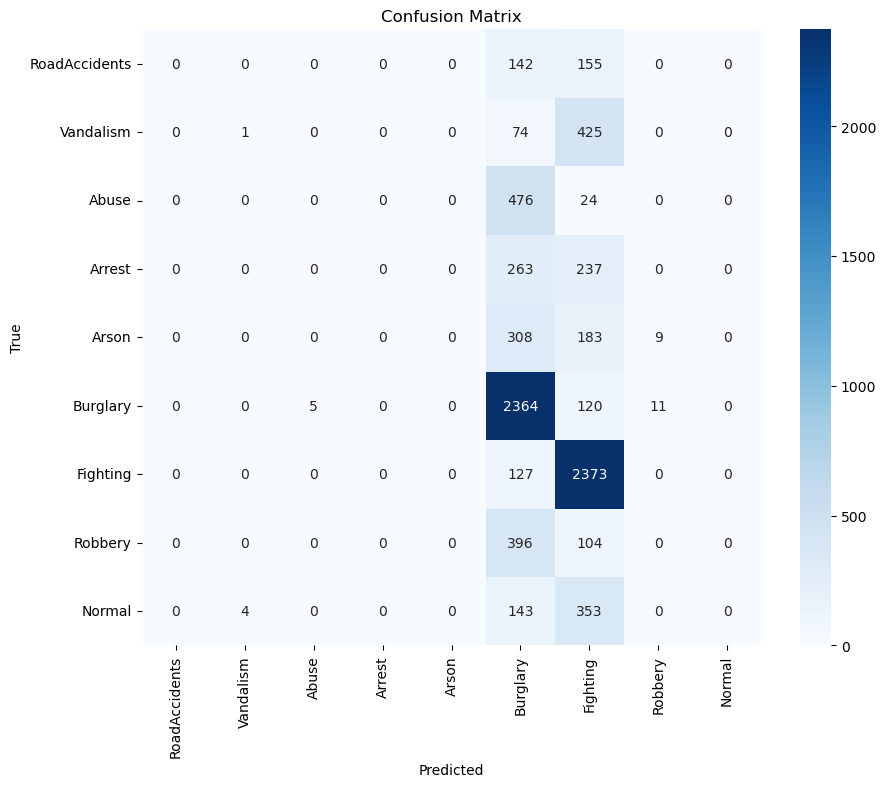

In [30]:
# Plot confusion matrix
cm = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=subfolders_to_copy + ['Normal'], yticklabels=subfolders_to_copy + ['Normal'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

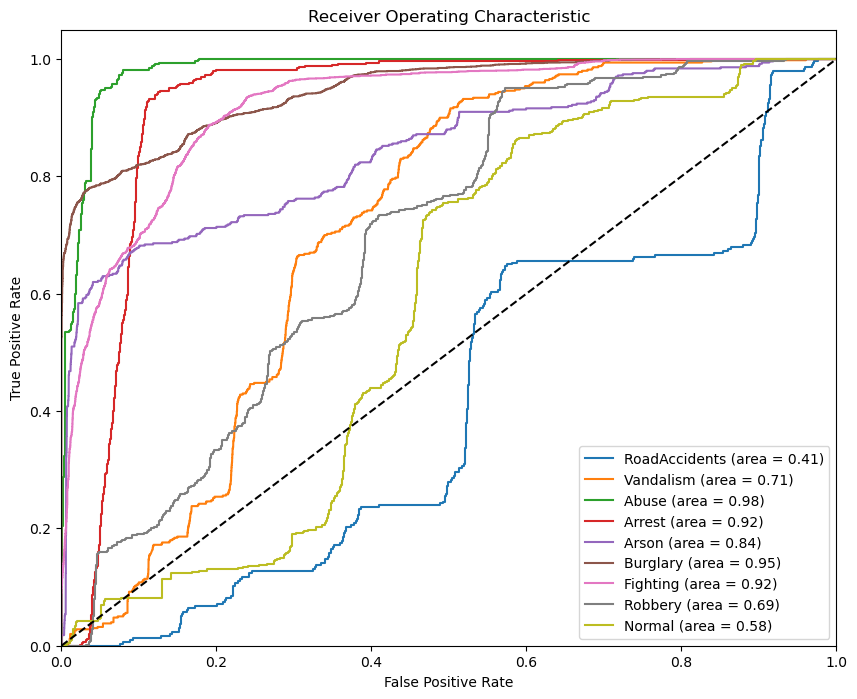

In [31]:
# Plot ROC curves
plt.figure(figsize=(10, 8))
for i, subfolder in enumerate(subfolders_to_copy + ['Normal']):
    fpr, tpr, _ = roc_curve(test_labels == i, test_probabilities[:, i])
    roc_auc = roc_auc_score(test_labels == i, test_probabilities[:, i])
    plt.plot(fpr, tpr, label=f'{subfolder} (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

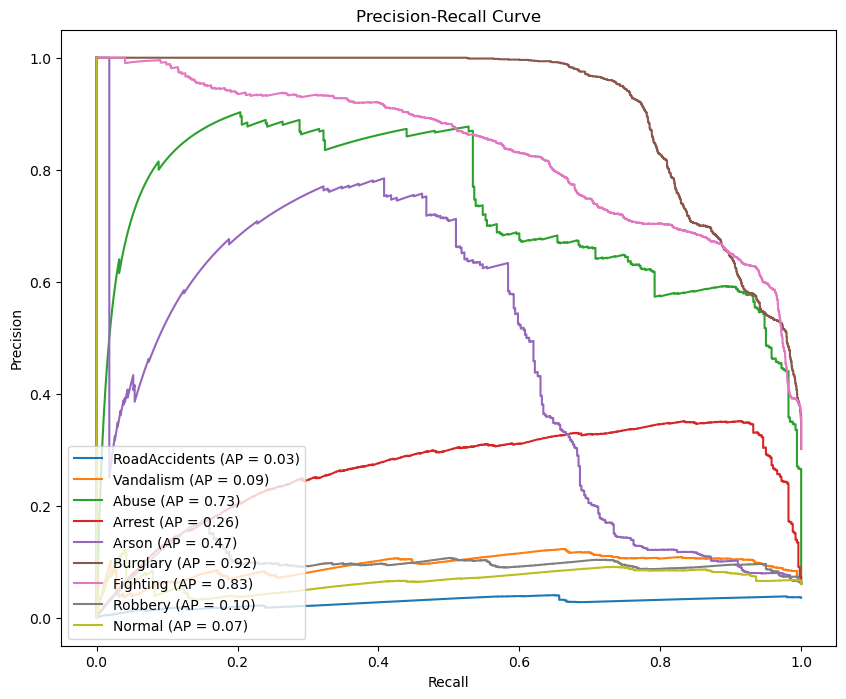

In [32]:
# Plot Precision-Recall curves
plt.figure(figsize=(10, 8))
for i, subfolder in enumerate(subfolders_to_copy + ['Normal']):
    precision, recall, _ = precision_recall_curve(test_labels == i, test_probabilities[:, i])
    average_precision = average_precision_score(test_labels == i, test_probabilities[:, i])
    plt.plot(recall, precision, label=f'{subfolder} (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()